## 8 基于深度学习的时间序列分析方法
### 8.1 LSTM长短期记忆网络

### 8.1.1 使用pytorch搭建

In [101]:
import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

**数据导入和准备**

In [102]:
# 导入酒精销售数据
df = pd.read_csv('data\Alcohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

325

In [103]:
df.head()  # 观察数据集，这是一个单变量时间序列

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


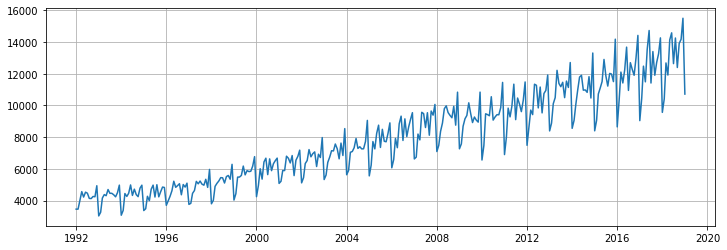

In [104]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

In [105]:
y = df['S4248SM144NCEN'].values.astype(float)

test_size = 12

# 划分训练和测试集，最后12个值作为测试集
train_set = y[:-test_size]
test_set = y[-test_size:]

In [106]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [107]:
# 归一化至[-1,1]区间，为了获得更好的训练效果
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

**创建时间序列训练集**

In [108]:
# 转换成 tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# 定义时间窗口，注意和前面的test size不是一个概念
window_size = 12

# 这个函数的目的是为了从原时间序列中抽取出训练样本，也就是用第一个值到第十二个值作为X输入，预测第十三个值作为y输出，这是一个用于训练的数据点，时间窗口向后滑动以此类推
def input_data(seq,ws):  
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out


train_data = input_data(train_norm,window_size)
len(train_data)  # 等于325（原始数据集长度）-12（测试集长度）-12（时间窗口） 

301

In [109]:
# 观察某一个数据点
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

**定义模型**

In [110]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # 定义LSTM层
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # 定义全连接层
        self.linear = nn.Linear(hidden_size,output_size)
        
        # 初始化h0，c0
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        # 前向传播的过程是输入->LSTM层->全连接层->输出
        
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM
        # 在观察查看LSTM输入的维度，LSTM的第一个输入input_size维度是(L, N, H_in), L是序列长度，N是batch size，H_in是输入尺寸，也就是变量个数
        # LSTM的第二个输入是一个元组，包含了h0,c0两个元素，这两个元素的维度都是（D∗num_layers,N,H_out)，D=1表示单向网络，num_layers表示多少个LSTM层叠加，N是batch size，H_out表示隐层神经元个数
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        
        pred = self.linear(lstm_out.view(len(seq),-1)) 
        return pred[-1]  # 输出只用取最后一个值

**定义损失函数和优化函数**

In [111]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [112]:
# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


**训练模型**

In [113]:
epochs = 100

start_time = time.time()

for epoch in range(epochs):
    
    for seq, y_train in train_data:
        
        # 每次更新参数前都梯度归零和初始化
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25310209
Epoch:  2 Loss: 0.37532014
Epoch:  3 Loss: 0.39027199
Epoch:  4 Loss: 0.34934705
Epoch:  5 Loss: 0.33085635
Epoch:  6 Loss: 0.33229983
Epoch:  7 Loss: 0.32670355
Epoch:  8 Loss: 0.32074136
Epoch:  9 Loss: 0.30653533
Epoch: 10 Loss: 0.29518044
Epoch: 11 Loss: 0.26934361
Epoch: 12 Loss: 0.25998521
Epoch: 13 Loss: 0.24665757
Epoch: 14 Loss: 0.22403948
Epoch: 15 Loss: 0.18602757
Epoch: 16 Loss: 0.18561246
Epoch: 17 Loss: 0.17209382
Epoch: 18 Loss: 0.25161767
Epoch: 19 Loss: 0.22557595
Epoch: 20 Loss: 0.17449248
Epoch: 21 Loss: 0.20236212
Epoch: 22 Loss: 0.20818113
Epoch: 23 Loss: 0.16646339
Epoch: 24 Loss: 0.17596811
Epoch: 25 Loss: 0.11981886
Epoch: 26 Loss: 0.09510354
Epoch: 27 Loss: 0.04497015
Epoch: 28 Loss: 0.06977511
Epoch: 29 Loss: 0.00583372
Epoch: 30 Loss: 0.10420544
Epoch: 31 Loss: 0.00130300
Epoch: 32 Loss: 0.01704546
Epoch: 33 Loss: 0.00454277
Epoch: 34 Loss: 0.01743382
Epoch: 35 Loss: 0.05319921
Epoch: 36 Loss: 0.01346177
Epoch: 37 Loss: 0.00281374
E

**模型预测和评估**

In [115]:
future = 12

# 选取序列最后12个值开始预测
preds = train_norm[-window_size:].tolist()

# 设置成eval模式
model.eval()

# 循环的每一步表示向时间序列向后滑动一格
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [116]:
# 逆归一化还原真实值
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

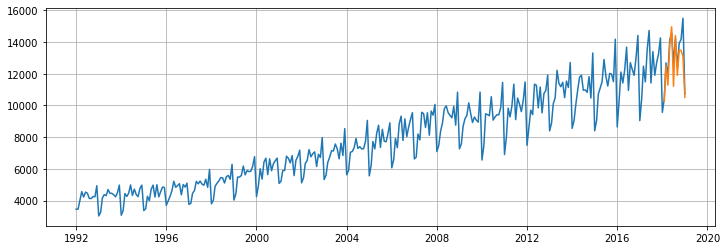

In [117]:
# 对比真实值和预测值
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(df['S4248SM144NCEN'])
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.plot(x,true_predictions)
plt.show()

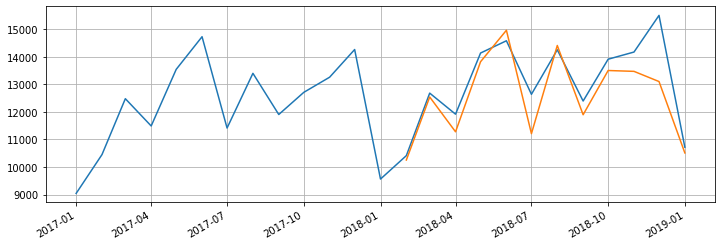

In [118]:
# 放大看
fig = plt.figure(figsize=(12,4))
plt.grid(True)
fig.autofmt_xdate()

plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

**预测未来的时间序列值**

In [193]:
# 重新开始训练
epochs = 100

# 切回到训练模式
model.train()

y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)


start_time = time.time()

for epoch in range(epochs):
    
    for seq, y_train in all_data:  
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02637003
Epoch:  2 Loss: 0.02235967
Epoch:  3 Loss: 0.01420650
Epoch:  4 Loss: 0.01096698
Epoch:  5 Loss: 0.01132137
Epoch:  6 Loss: 0.01067625
Epoch:  7 Loss: 0.01385082
Epoch:  8 Loss: 0.01225379
Epoch:  9 Loss: 0.01069641
Epoch: 10 Loss: 0.01001978
Epoch: 11 Loss: 0.00892048
Epoch: 12 Loss: 0.00881878
Epoch: 13 Loss: 0.00787867
Epoch: 14 Loss: 0.00793300
Epoch: 15 Loss: 0.00654336
Epoch: 16 Loss: 0.00477153
Epoch: 17 Loss: 0.00421579
Epoch: 18 Loss: 0.00813891
Epoch: 19 Loss: 0.00435803
Epoch: 20 Loss: 0.00231854
Epoch: 21 Loss: 0.00287038
Epoch: 22 Loss: 0.00277172
Epoch: 23 Loss: 0.00316620
Epoch: 24 Loss: 0.00285987
Epoch: 25 Loss: 0.00255703
Epoch: 26 Loss: 0.00237400
Epoch: 27 Loss: 0.00013880
Epoch: 28 Loss: 0.00067541
Epoch: 29 Loss: 0.00265941
Epoch: 30 Loss: 0.00173528
Epoch: 31 Loss: 0.00183163
Epoch: 32 Loss: 0.00133842
Epoch: 33 Loss: 0.00051252
Epoch: 34 Loss: 0.00032429
Epoch: 35 Loss: 0.00007254
Epoch: 36 Loss: 0.00043622
Epoch: 37 Loss: 0.00015376
E

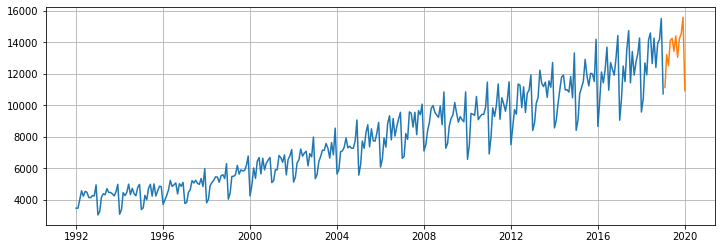

In [196]:
# 重新预测
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():

        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())


true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))


x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

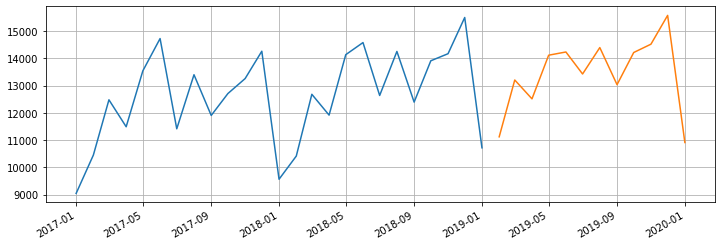

In [195]:
fig = plt.figure(figsize=(12,4))
plt.grid(True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

### 8.1.2 使用Darts调用

In [85]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [89]:
df = pd.read_csv('data\Alcohol_Sales.csv')

In [90]:
series = TimeSeries.from_dataframe(df, 'DATE', 'S4248SM144NCEN')

In [126]:
# 划分训练集和测试集
train, val = series.split_after(pd.Timestamp('20170101'))

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# 创建年和月的协变量序列
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=400),
                                             attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('20170101'))

In [131]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=100,
    dropout=0,
    batch_size=1,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3},
    model_name='Alcohol_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=12,
    input_chunk_length=12,
    force_reset=True
)

In [132]:
my_model.fit(train_transformed, covariates=cov_train, val_series=val_transformed, val_covariates=cov_val, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

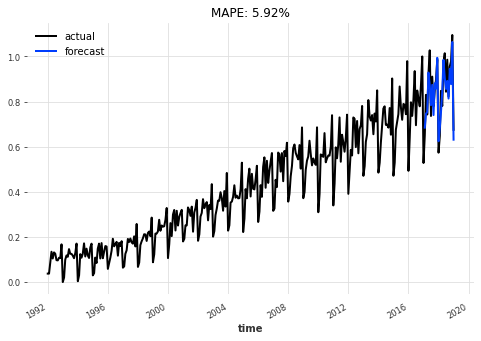

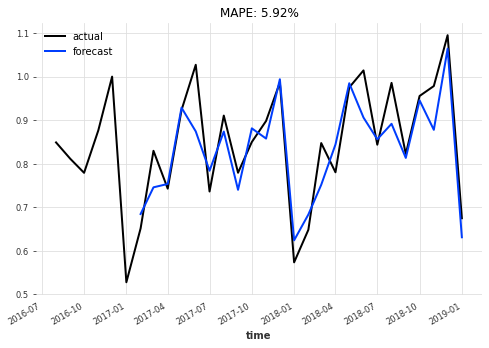

In [135]:
def eval_model(model, lag):
    pred_series = model.predict(n=24,covariates=covariates)
    plt.figure(figsize=(8,5))
    series_transformed[-lag:].plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();

eval_model(my_model,0)
eval_model(my_model,30)

### 8.2 CNN卷积神经网络

In [127]:
# 使用和上一节中LSTM准备好的相同数据样本
# 构建一个简单的1D CNN模型
class CNNnetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1d = nn.Conv1d(1,64,kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64*11,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        # 该模型的网络结构为 一维卷积层 -> Relu层 -> Flatten -> 全连接层1 -> 全连接层2 
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [128]:
torch.manual_seed(101)
model =CNNnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

CNNnetwork(
  (conv1d): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=704, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [135]:
# CNN用到的模型参数更少
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   128
    64
 35200
    50
    50
     1
______
 35493


In [130]:
epochs = 100
model.train()
start_time = time.time()

for epoch in range(epochs):
    
    for seq, y_train in train_data:
        
        # 每次更新参数前都梯度归零和初始化
        optimizer.zero_grad()

        
        y_pred = model(seq.reshape(1,1,-1))
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00185507
Epoch:  2 Loss: 0.00192179
Epoch:  3 Loss: 0.00401257
Epoch:  4 Loss: 0.00355381
Epoch:  5 Loss: 0.00576449
Epoch:  6 Loss: 0.00383969
Epoch:  7 Loss: 0.00159378
Epoch:  8 Loss: 0.00312686
Epoch:  9 Loss: 0.00007567
Epoch: 10 Loss: 0.00109411
Epoch: 11 Loss: 0.00089691
Epoch: 12 Loss: 0.00071857
Epoch: 13 Loss: 0.00002232
Epoch: 14 Loss: 0.00011689
Epoch: 15 Loss: 0.00052011
Epoch: 16 Loss: 0.00274869
Epoch: 17 Loss: 0.00262571
Epoch: 18 Loss: 0.00222251
Epoch: 19 Loss: 0.00404785
Epoch: 20 Loss: 0.00227435
Epoch: 21 Loss: 0.00332918
Epoch: 22 Loss: 0.00035685
Epoch: 23 Loss: 0.00143041
Epoch: 24 Loss: 0.00009634
Epoch: 25 Loss: 0.00113863
Epoch: 26 Loss: 0.00001641
Epoch: 27 Loss: 0.00567199
Epoch: 28 Loss: 0.00033592
Epoch: 29 Loss: 0.00127910
Epoch: 30 Loss: 0.00365015
Epoch: 31 Loss: 0.00425193
Epoch: 32 Loss: 0.00266863
Epoch: 33 Loss: 0.00367663
Epoch: 34 Loss: 0.00326027
Epoch: 35 Loss: 0.00218321
Epoch: 36 Loss: 0.00346854
Epoch: 37 Loss: 0.00311081
E

In [131]:
future = 12

# 选取序列最后12个值开始预测
preds = train_norm[-window_size:].tolist()

# 设置成eval模式
model.eval()

# 循环的每一步表示向时间序列向后滑动一格
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        preds.append(model(seq.reshape(1,1,-1)).item())

In [132]:
# 逆归一化还原真实值
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

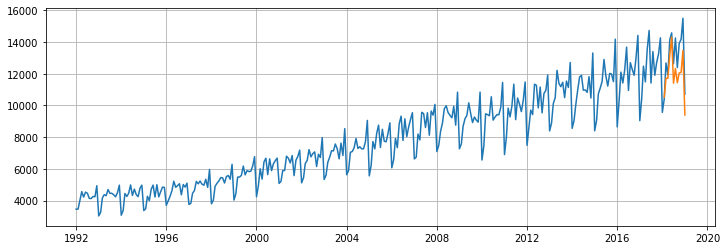

In [133]:
# 对比真实值和预测值
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(df['S4248SM144NCEN'])
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.plot(x,true_predictions)
plt.show()

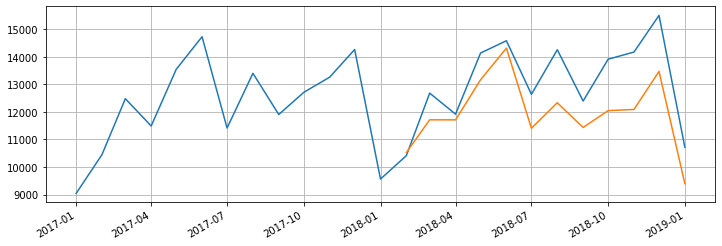

In [134]:
# 放大看
fig = plt.figure(figsize=(12,4))
plt.grid(True)
fig.autofmt_xdate()

plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()